In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [2]:
# Define and initialize model
class NeuralNetworkMVEv2(nn.Module):
    def __init__(self, npix):
        super(NeuralNetworkMVEv2, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('f_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=32))
        self.regressor.add_module('r_sig2', nn.Sigmoid())
        self.regressor.add_module('r_fc3', nn.Linear(in_features=32, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

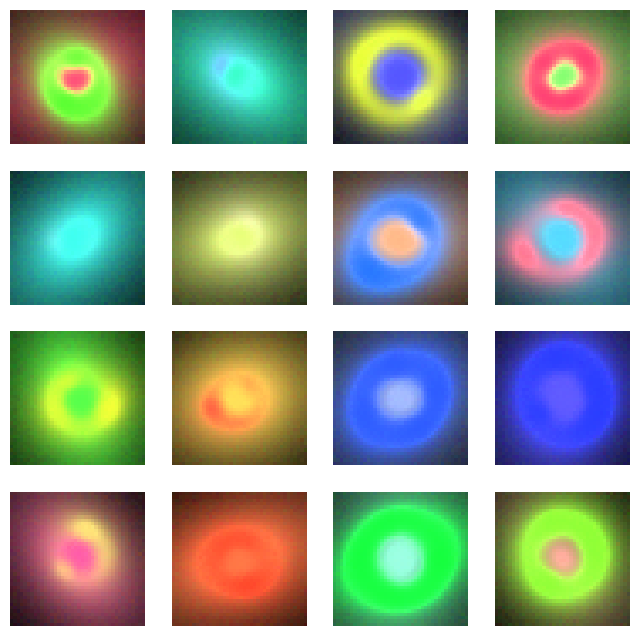

In [4]:
# Visualize source data
visualize_data(source_data)

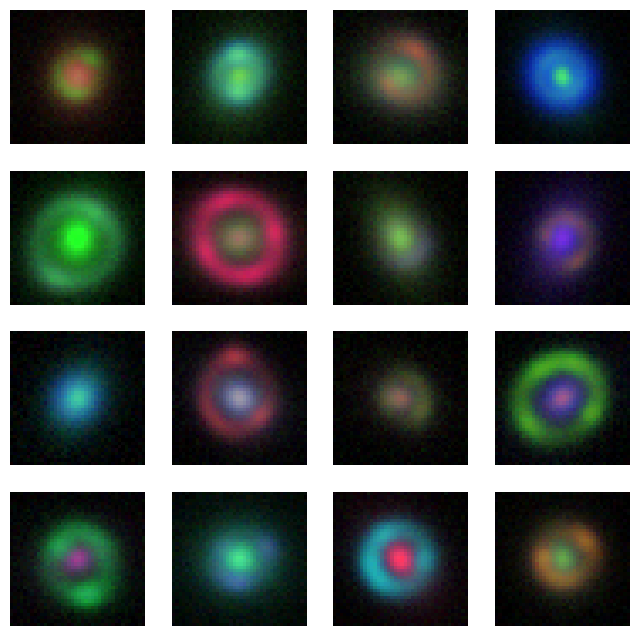

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 1e-5
n_epoch = 150
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.4

In [7]:
# Initialize model
model = NeuralNetworkMVEv2(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
from torchsummary import summary
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
             ReLU-14                  [

In [9]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/mve_v5_NNv2_aug5_0000"

## Train

Beginning Training...
Generating Isomap...


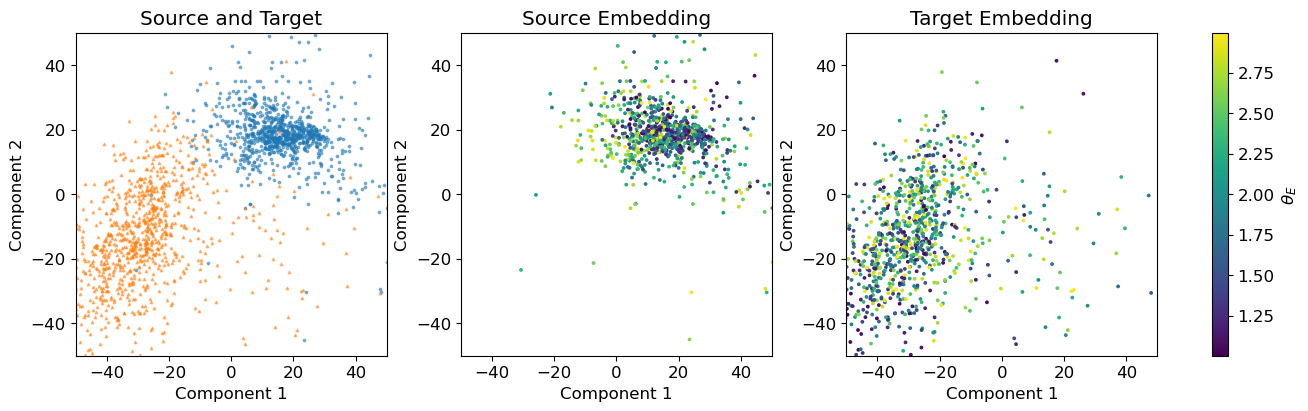


Epoch 0: 13.84s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3071
	Train Regression Loss: : 1.7594
	Train Mve Loss: : 0.9357
	Train R2 Score: : -4.5384
 Validation Statistics:
	Val Source Regression Loss: : 0.7025
	Val Target Regression Loss: : 0.6837
	Val Source R2 Score: : -1.1869
	Val Target R2 Score: : -1.1568
	Val Source Mve Loss: : 0.3082
	Val Target Mve Loss: : 0.2990
Saving Model MVE... Done.

Epoch 1: 14.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1797
	Train Regression Loss: : 0.5581
	Train Mve Loss: : 0.1778
	Train R2 Score: : -0.7428
 Validation Statistics:
	Val Source Regression Loss: : 0.5026
	Val Target Regression Loss: : 0.4896
	Val Source R2 Score: : -0.5551
	Val Target R2 Score: : -0.5367
	Val Source Mve Loss: : 0.0969
	Val Target Mve Loss: : 0.0897
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 13.99s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1572
	Train Regress

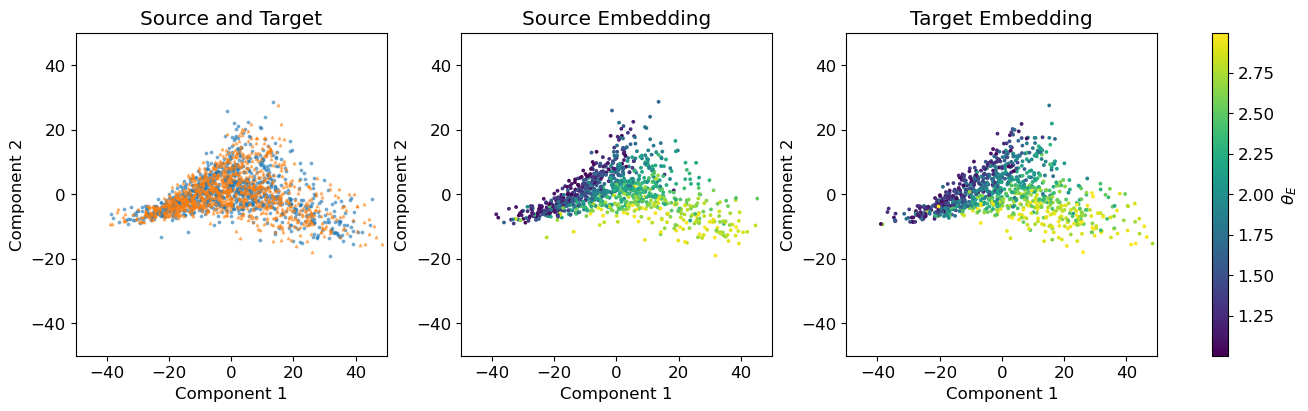

Saving Model... Done.

Epoch 20: 13.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1394
	Train Regression Loss: : 0.0279
	Train Mve Loss: : -0.0456
	Train R2 Score: : 0.9117
 Validation Statistics:
	Val Source Regression Loss: : 0.0290
	Val Target Regression Loss: : 0.0320
	Val Source R2 Score: : 0.9093
	Val Target R2 Score: : 0.8983
	Val Source Mve Loss: : -0.0470
	Val Target Mve Loss: : -0.0444
Saving Model... Done.

Epoch 21: 14.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1387
	Train Regression Loss: : 0.0273
	Train Mve Loss: : -0.0462
	Train R2 Score: : 0.9134
 Validation Statistics:
	Val Source Regression Loss: : 0.0285
	Val Target Regression Loss: : 0.0323
	Val Source R2 Score: : 0.9122
	Val Target R2 Score: : 0.8959
	Val Source Mve Loss: : -0.0692
	Val Target Mve Loss: : -0.0665
Saving Model MVE... Done.

Epoch 22: 14.55s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1401
	Train Regressi

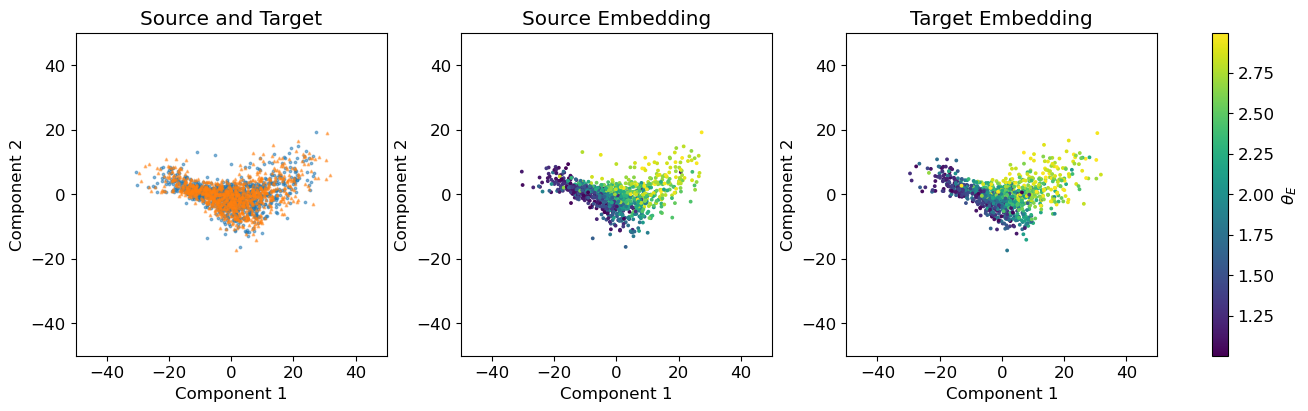

Saving Model... Done.

Epoch 40: 11.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1445
	Train Regression Loss: : 0.0230
	Train Mve Loss: : -0.0568
	Train R2 Score: : 0.9270
 Validation Statistics:
	Val Source Regression Loss: : 0.0239
	Val Target Regression Loss: : 0.0281
	Val Source R2 Score: : 0.9251
	Val Target R2 Score: : 0.9106
	Val Source Mve Loss: : -0.0609
	Val Target Mve Loss: : -0.0557
Saving Model... Done.

Epoch 41: 12.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1454
	Train Regression Loss: : 0.0225
	Train Mve Loss: : -0.0560
	Train R2 Score: : 0.9287
 Validation Statistics:
	Val Source Regression Loss: : 0.0238
	Val Target Regression Loss: : 0.0293
	Val Source R2 Score: : 0.9264
	Val Target R2 Score: : 0.9069
	Val Source Mve Loss: : -0.0540
	Val Target Mve Loss: : -0.0472

Epoch 42: 14.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1450
	Train Regression Loss: : 0.0225
	Train M

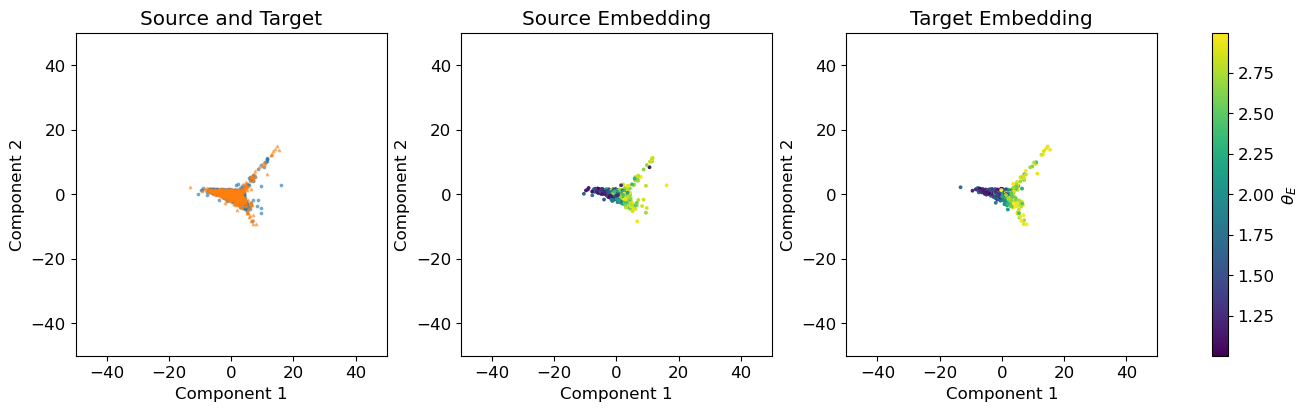


Epoch 60: 13.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1599
	Train Regression Loss: : 0.0271
	Train Mve Loss: : -0.0799
	Train R2 Score: : 0.9145
 Validation Statistics:
	Val Source Regression Loss: : 0.0286
	Val Target Regression Loss: : 0.0369
	Val Source R2 Score: : 0.9104
	Val Target R2 Score: : 0.8820
	Val Source Mve Loss: : -0.0764
	Val Target Mve Loss: : -0.0658

Epoch 61: 12.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1598
	Train Regression Loss: : 0.0271
	Train Mve Loss: : -0.0817
	Train R2 Score: : 0.9148
 Validation Statistics:
	Val Source Regression Loss: : 0.0281
	Val Target Regression Loss: : 0.0355
	Val Source R2 Score: : 0.9120
	Val Target R2 Score: : 0.8874
	Val Source Mve Loss: : -0.0749
	Val Target Mve Loss: : -0.0647

Epoch 62: 12.93s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1604
	Train Regression Loss: : 0.0270
	Train Mve Loss: : -0.0820
	Train R2 Score: : 0.9149

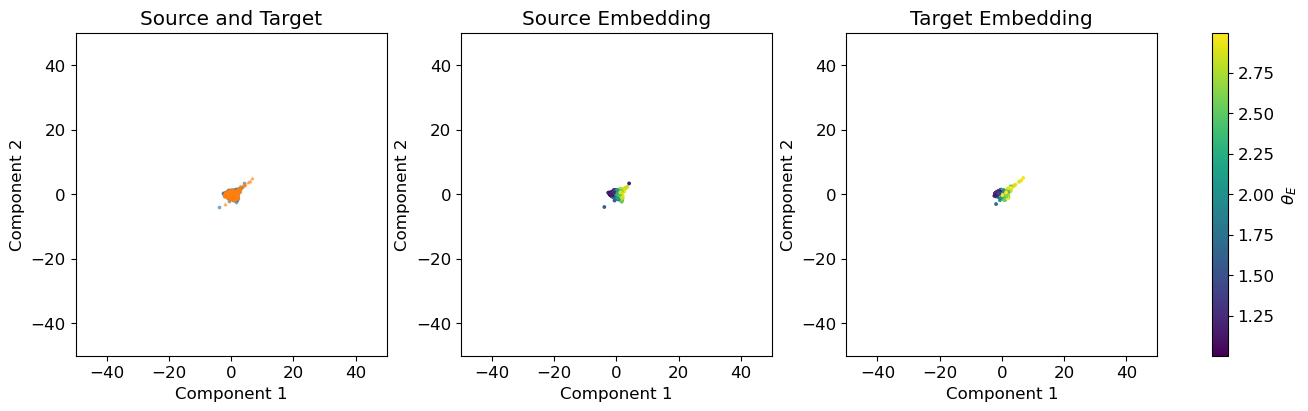


Epoch 80: 19.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1669
	Train Regression Loss: : 0.0275
	Train Mve Loss: : -0.1065
	Train R2 Score: : 0.9133
 Validation Statistics:
	Val Source Regression Loss: : 0.0294
	Val Target Regression Loss: : 0.0332
	Val Source R2 Score: : 0.9084
	Val Target R2 Score: : 0.8950
	Val Source Mve Loss: : -0.0923
	Val Target Mve Loss: : -0.0858

Epoch 81: 13.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1674
	Train Regression Loss: : 0.0275
	Train Mve Loss: : -0.1084
	Train R2 Score: : 0.9132
 Validation Statistics:
	Val Source Regression Loss: : 0.0272
	Val Target Regression Loss: : 0.0330
	Val Source R2 Score: : 0.9153
	Val Target R2 Score: : 0.8949
	Val Source Mve Loss: : -0.0931
	Val Target Mve Loss: : -0.0830

Epoch 82: 17.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1669
	Train Regression Loss: : 0.0273
	Train Mve Loss: : -0.1098
	Train R2 Score: : 0.9138

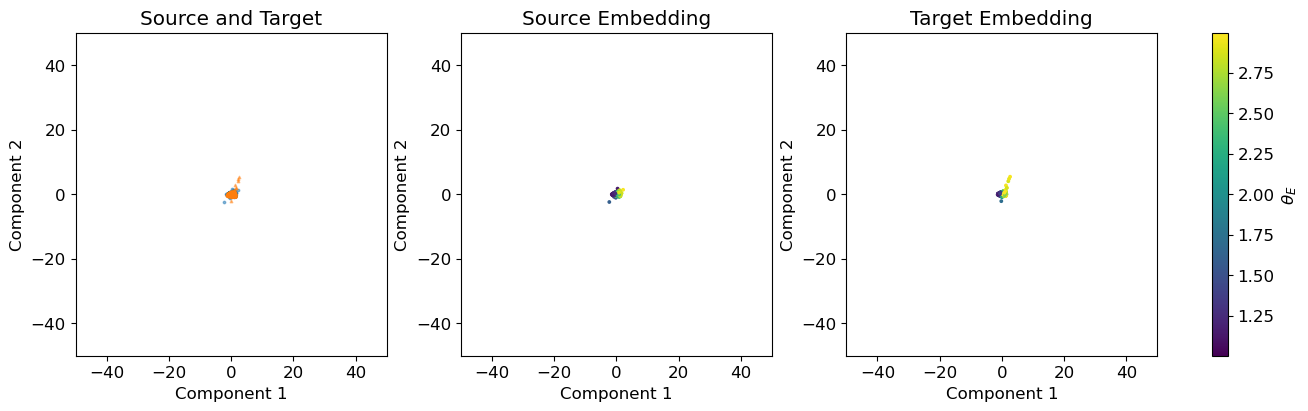


Epoch 100: 15.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1628
	Train Regression Loss: : 0.0269
	Train Mve Loss: : -0.1439
	Train R2 Score: : 0.9151
 Validation Statistics:
	Val Source Regression Loss: : 0.0298
	Val Target Regression Loss: : 0.0332
	Val Source R2 Score: : 0.9054
	Val Target R2 Score: : 0.8950
	Val Source Mve Loss: : -0.1214
	Val Target Mve Loss: : -0.1130

Epoch 101: 14.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1622
	Train Regression Loss: : 0.0271
	Train Mve Loss: : -0.1473
	Train R2 Score: : 0.9147
 Validation Statistics:
	Val Source Regression Loss: : 0.0285
	Val Target Regression Loss: : 0.0359
	Val Source R2 Score: : 0.9110
	Val Target R2 Score: : 0.8834
	Val Source Mve Loss: : -0.1609
	Val Target Mve Loss: : -0.1461

Epoch 102: 13.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1609
	Train Regression Loss: : 0.0266
	Train Mve Loss: : -0.1484
	Train R2 Score: : 0.9

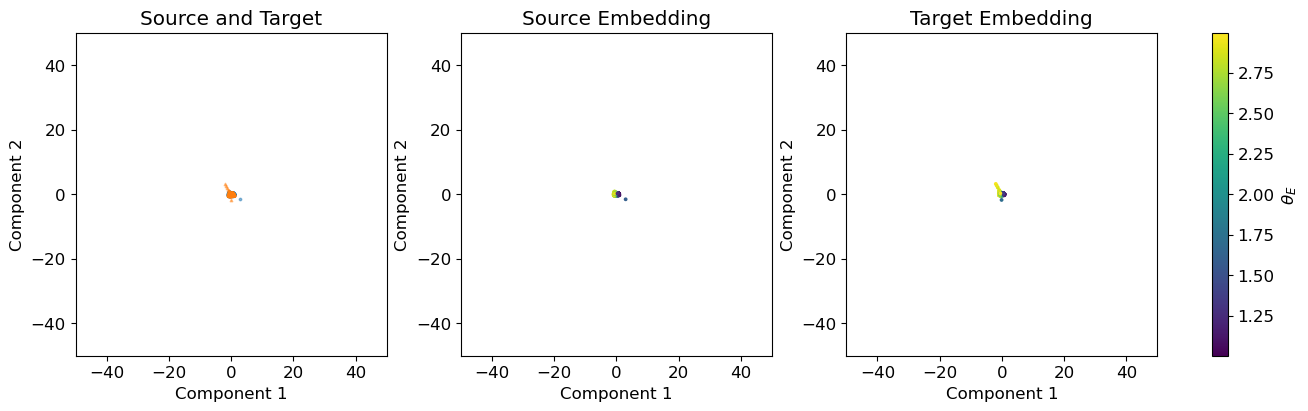

Saving Model MVE... Done.

Epoch 120: 12.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1612
	Train Regression Loss: : 0.0260
	Train Mve Loss: : -0.1944
	Train R2 Score: : 0.9179
 Validation Statistics:
	Val Source Regression Loss: : 0.0261
	Val Target Regression Loss: : 0.0315
	Val Source R2 Score: : 0.9181
	Val Target R2 Score: : 0.8979
	Val Source Mve Loss: : -0.1954
	Val Target Mve Loss: : -0.1797
Saving Model MVE... Done.

Epoch 121: 13.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1622
	Train Regression Loss: : 0.0263
	Train Mve Loss: : -0.1977
	Train R2 Score: : 0.9162
 Validation Statistics:
	Val Source Regression Loss: : 0.0258
	Val Target Regression Loss: : 0.0301
	Val Source R2 Score: : 0.9192
	Val Target R2 Score: : 0.9036
	Val Source Mve Loss: : -0.1924
	Val Target Mve Loss: : -0.1792

Epoch 122: 12.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1614
	Train Regression Loss: : 0.02

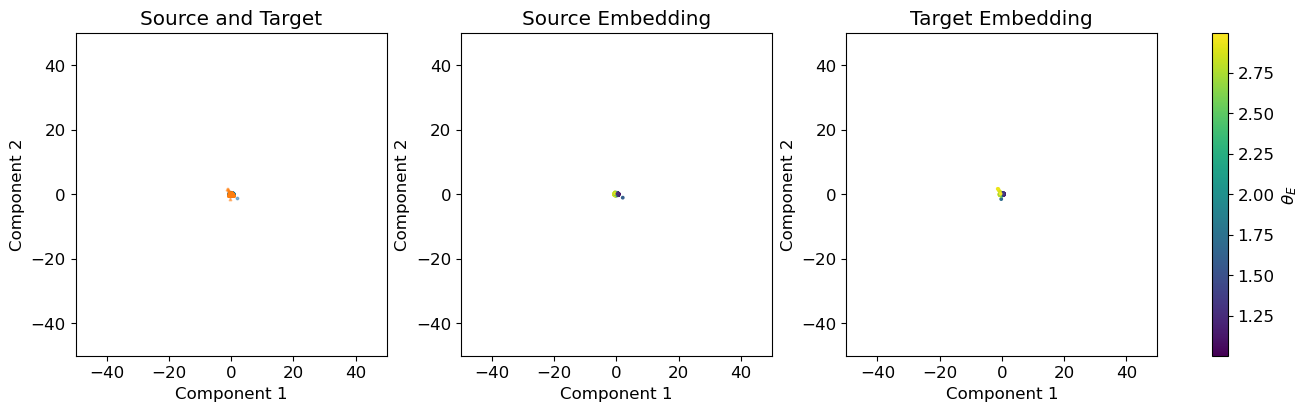


Epoch 140: 13.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1632
	Train Regression Loss: : 0.0242
	Train Mve Loss: : -0.2619
	Train R2 Score: : 0.9235
 Validation Statistics:
	Val Source Regression Loss: : 0.0249
	Val Target Regression Loss: : 0.0308
	Val Source R2 Score: : 0.9212
	Val Target R2 Score: : 0.9015
	Val Source Mve Loss: : -0.2929
	Val Target Mve Loss: : -0.2734
Saving Model MVE... Done.

Epoch 141: 15.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1635
	Train Regression Loss: : 0.0243
	Train Mve Loss: : -0.2654
	Train R2 Score: : 0.9230
 Validation Statistics:
	Val Source Regression Loss: : 0.0246
	Val Target Regression Loss: : 0.0287
	Val Source R2 Score: : 0.9224
	Val Target R2 Score: : 0.9090
	Val Source Mve Loss: : -0.2840
	Val Target Mve Loss: : -0.2680

Epoch 142: 14.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1633
	Train Regression Loss: : 0.0236
	Train Mve Loss: : -0.2

In [10]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [11]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [12]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

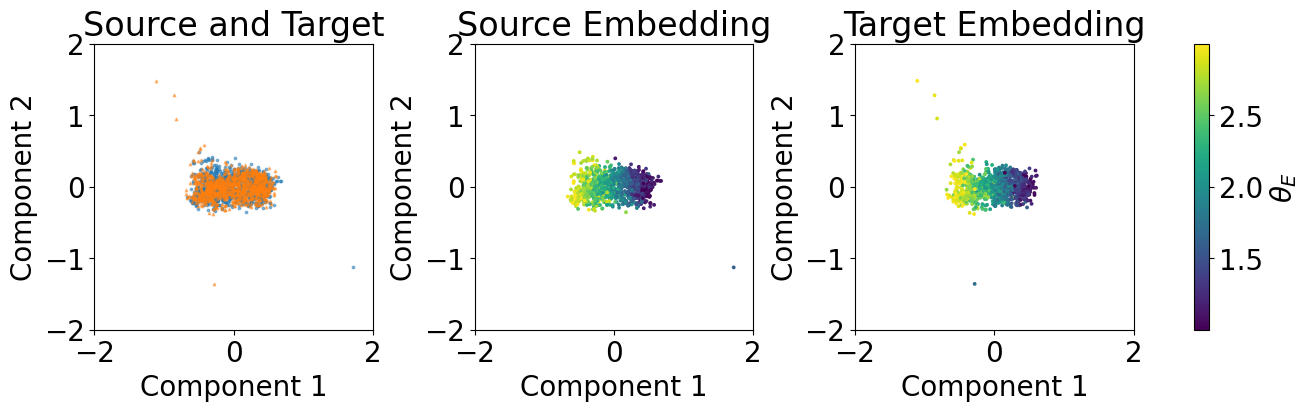

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [28]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 2)

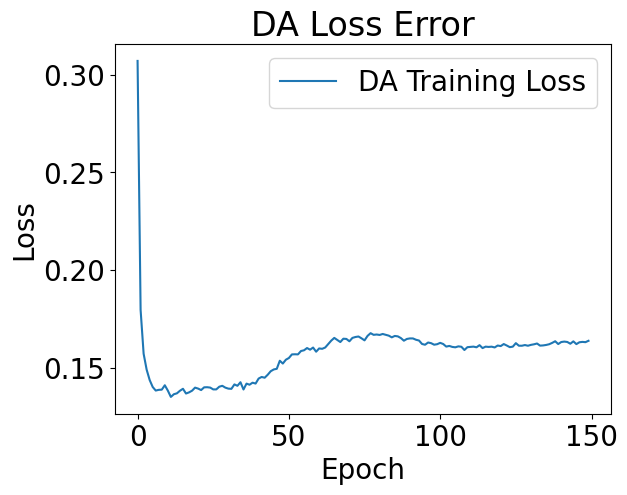

In [29]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

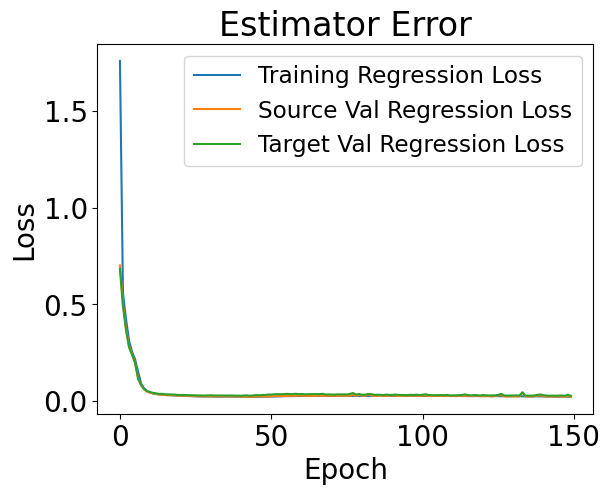

In [30]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

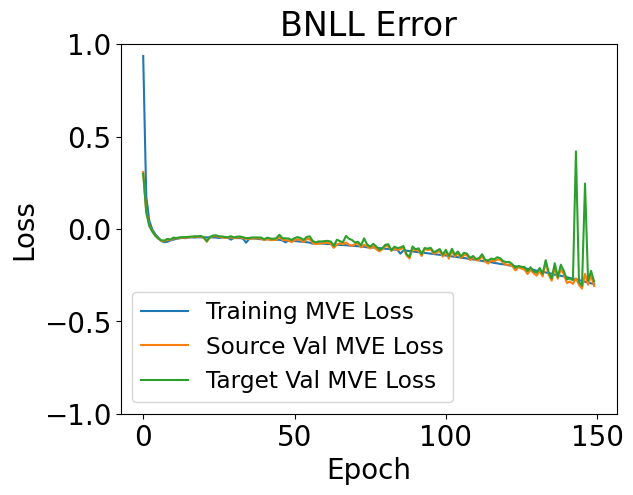

In [31]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

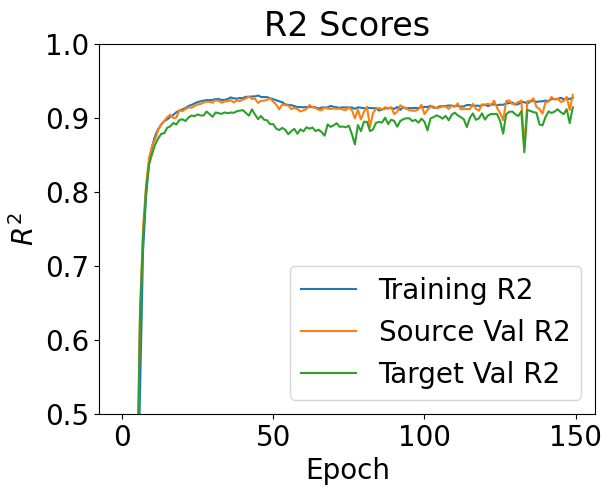

In [32]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [33]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9312


Text(0.5, 1.0, 'MMD | Source | R2: 0.931')

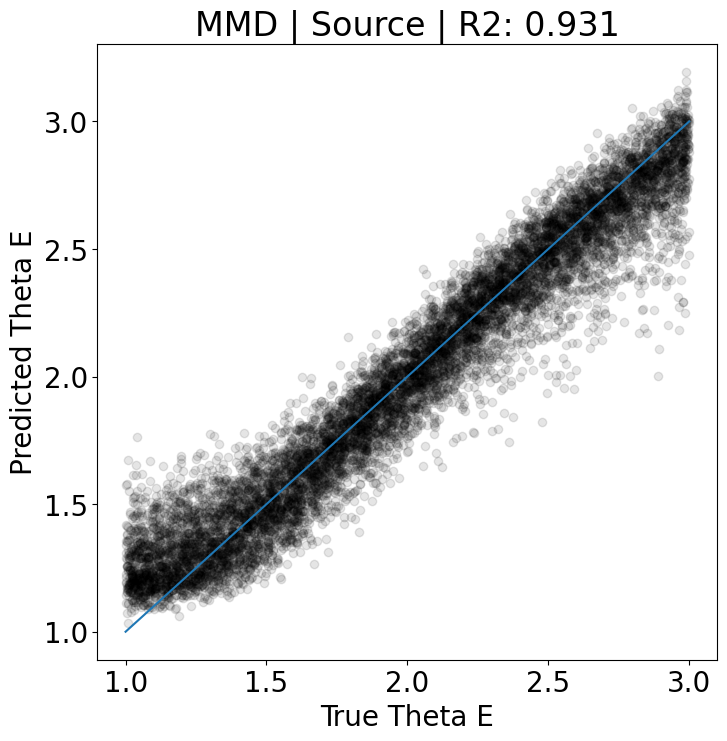

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.216')

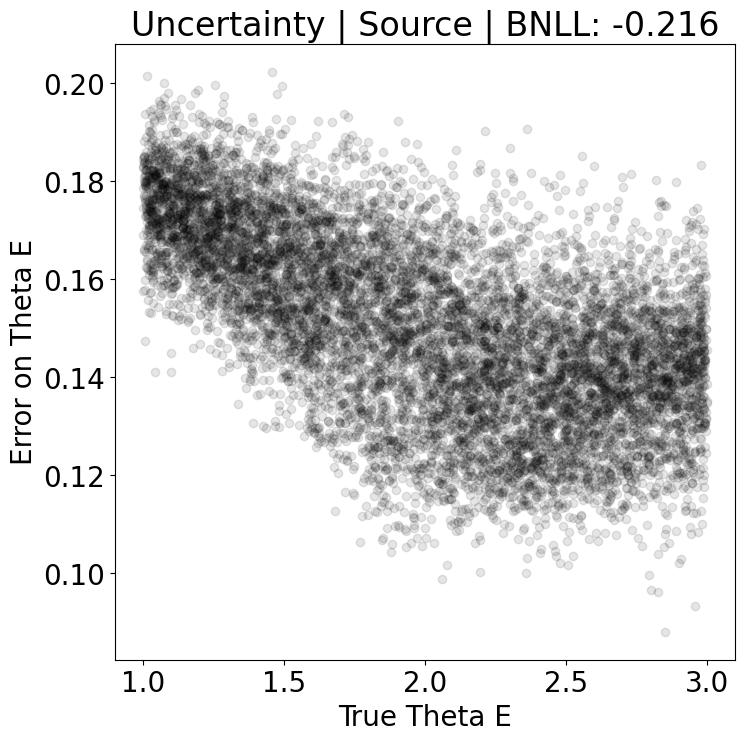

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [36]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9093


Text(0.5, 1.0, 'MMD | Target | R2: 0.909')

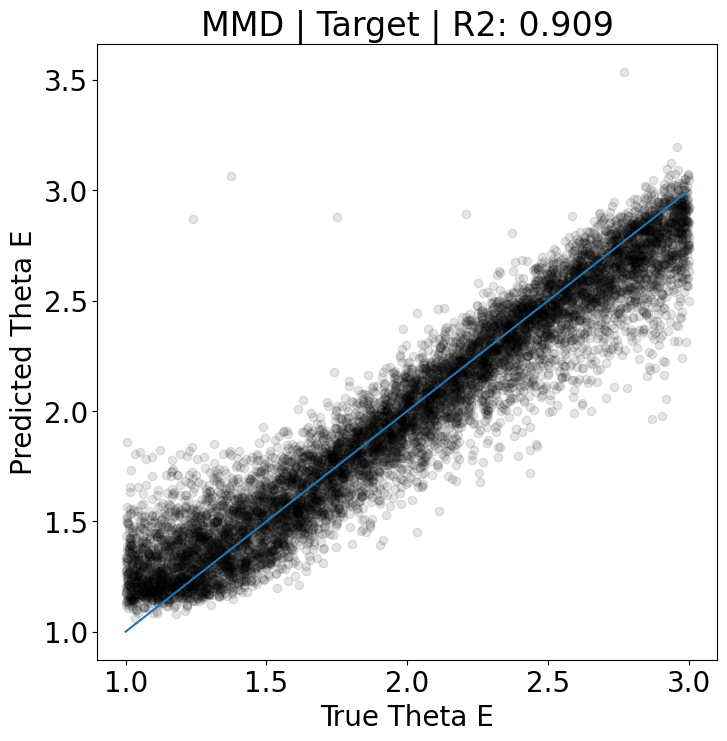

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.909')

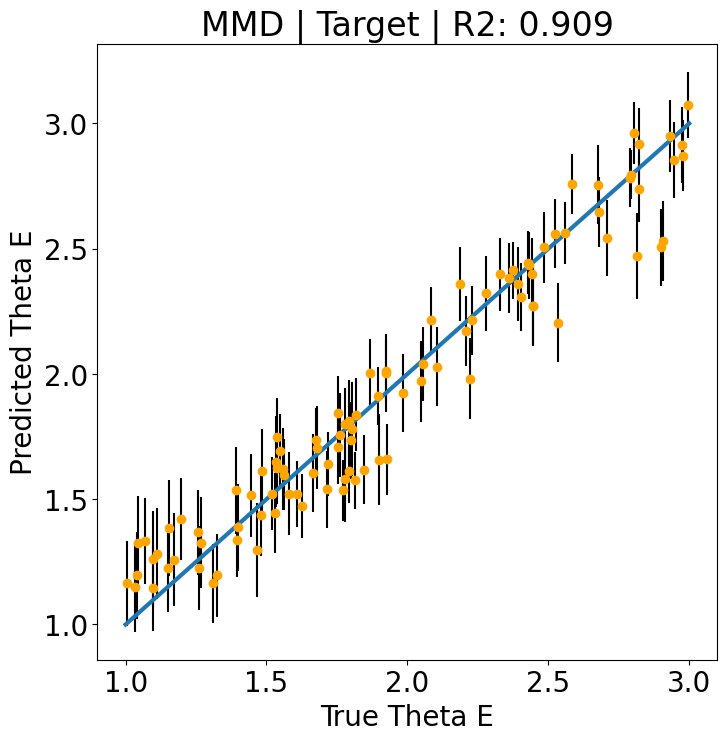

In [38]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.101')

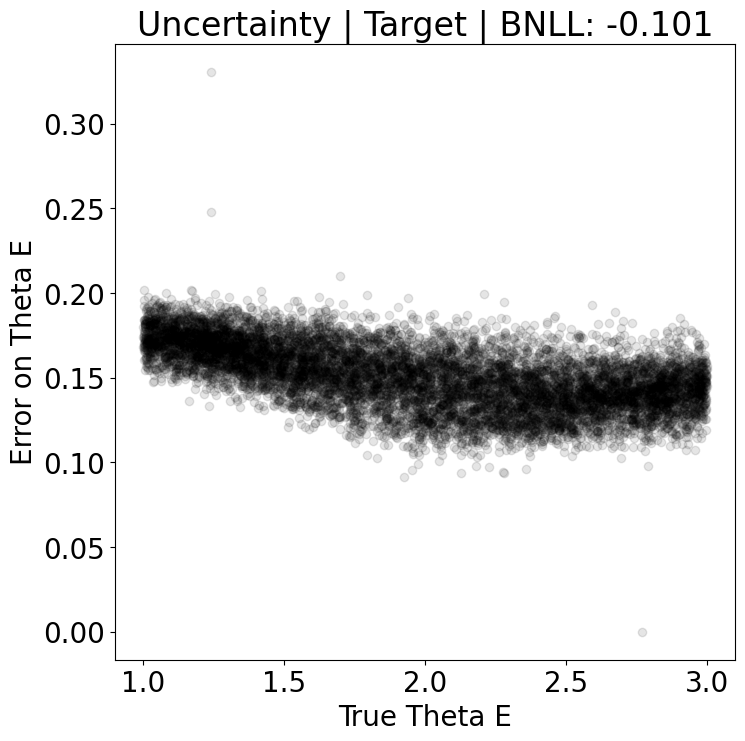

In [39]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [40]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

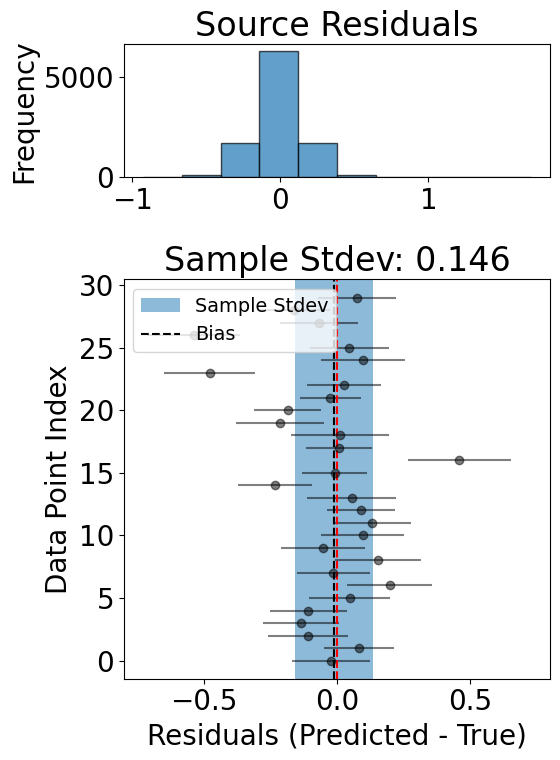

In [41]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

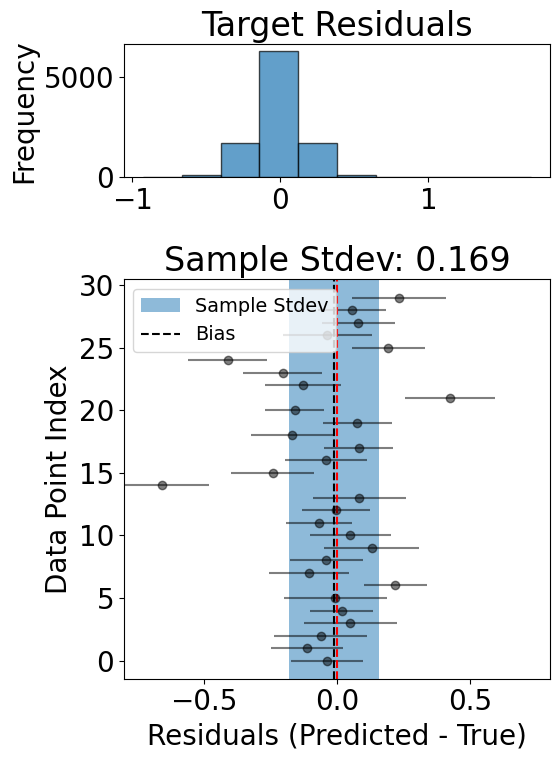

In [42]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()